Deep Learning & Reinforcement Learning
# **Group Assignment**
### **Highway Environment: Emergency Response Driving Challenge**
Professor: David Kremer

Assignment done by: 
- Adrian Marino
- Felipe Fischel
- Gilles Calderón
- Jean-Jacon Klat
- João André Pinho
- Nicholas Dieke
- Niccolo Borgato
- Max Heilingbrunner

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#  **Resolution**

##  **Part 0: Imports & Setup**

### **• Libraries and Module Imports:**

Importing the necessary libraries and modules to manipulate and interact with the dataset.

In [30]:
import gymnasium as gym
import highway_env

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import os
import numpy as np

import imageio
from IPython import display
import matplotlib.pyplot as plt
import pprint
import matplotlib.animation as animation
from pyvirtualdisplay import Display
import gym.wrappers
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
#!pip install highway-env

In [ ]:
#!pip install pyvirtualdisplay highway-env stable_baselines3

### **• Video Replay Setup:**

Creating a path for storing gameplay animations from the different tests.

In [26]:
# Creating a directory to save the video files
video_dir = '/path/to/video_dir'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part I: Setting Up the Environment and Action Space**

Define the environment and action space that will be used - "Highway-v0" and create an instance of it.

In [3]:
# Defining the type of environment.
environment_name = 'highway-v0'

# Creating an instance of it and setting the render mode as "human" so the environment can be seen on video.
env = gym.make(environment_name, render_mode="human")

c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [7]:
# Checking the current environment configuration.

pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


### **• Change the Action Space:**

Changing the action space from discrete to continuos.

In [3]:
# Checking the Default Action Space.
env.action_space

Discrete(5)

**Insight:** : As of now, the default action space uses 5 different actions:
 
 - **Lane Left**
 - **Idle**
 - **Lane Right**
 - **Faster**
 - **Slower**

In [8]:
# Changing the Default Action Space of the environment to Continuos, in order to allow the agent to directly set the low-level controls of the vehicle kinematics.
# This will allow the agent to change its steering angle and throttle (acceleration).
env.configure({
    "action": {
        "type": "ContinuousAction"
    }
})
env.reset()

(array([[ 1.        ,  0.9039406 ,  0.75      ,  0.3125    ,  0.        ],
        [ 1.        ,  0.10145508, -0.5       , -0.03188379,  0.        ],
        [ 1.        ,  0.20449375, -0.75      , -0.04452832,  0.        ],
        [ 1.        ,  0.30793422, -0.75      , -0.04818792,  0.        ],
        [ 1.        ,  0.42262217, -0.5       , -0.01568883,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': array([-0.09063949, -0.3238328 ], dtype=float32),
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 1.0,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [9]:
# Checking the New Action Space.
env.action_space

Box(-1.0, 1.0, (2,), float32)

**Insight:** : The new action space will be continuos with 2 different actions:
 
 - **Steering -** [-1 Full Left, +1 Full Right]
 - **Throttle -** [-1 Full Brake, +1 Full Acceleration]

 This change was performed in order for the car to be able to have a smoother and finer control over its actions, which can be beneficial in complex and dynamic environments like a highway.

### **• Change the Observation Space:**

Changing the observation space from array-based to image-based.

In [10]:
# Checking the Default Observation Space.
env.observation_space

Box(-inf, inf, (5, 5), float32)

**Insight:** The default Observation Space consists of a 2D 5x5 array, where each row corresponds to one vehicle in this environment and the columns correspond to different characteristics of that vehicle.

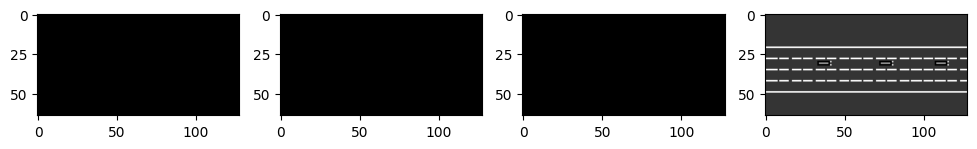

In [13]:
# Changing the Observation Space to a Grayscale Image based one.
%matplotlib inline
config = {
   "observation": {
       "type": "GrayscaleObservation",
       "observation_shape": (128, 64),
       "stack_size": 4,
       "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
       "scaling": 1.75,
   },
   "policy_frequency": 2
}

env.configure(config)
obs, info = env.reset()

fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
   ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

In [15]:
# Checking the Default Observation Space.
env.observation_space

Box(0, 255, (4, 128, 64), uint8)

**Insight:** The new Observation Space will consist of a 128x64 Grayscale four image stack from the Gameplay, where each image can take on a value from 0 (indicating black) to 255 (indicating white).

This change was performed in order to train a model that would present more similarity with the real-world data. As autonomous driving vehicles primarily rely on visual input from cameras, training an RL agent with similar image-based inputs can make the learned policies more directly tranferable to a real-world scenario. Additionally, as images encapsulate a wider array of spacial details, such as positioning of surrounding vehicles, lane markings, and other environmental features, the model may gain a more comprehensive and valuable understanding of the scene, facilitating its learning and precise decion making process.

In [29]:
# Wrapping the environment with Monitor wrapper to save the gameplays.
env = gym.wrappers.Monitor(env, video_dir, force=True)

AttributeError: module 'gym.wrappers' has no attribute 'Monitor'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part II: Running a Baseline of Random Episodes**

Let the agent take random actions in the environment in order to give a baseline of what to expect from an untrained agent.

In [23]:
# Defining the number of episodes - number of times the game will play itself either if:
#   A. The car visits all tiles.
#   B. Goes outside of the playfield and far from the track.
episodes = 5

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):
    
    # Reseting the environment to get the initial state - car starts at rest in the center of the road.
    state = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False
    
    # Initializing the score for the episode to 0.
    score = 0 
    
    # Starting a loop that continues until the episode is done.
    while not done:
        
        # Choosing an action randomly from the action space of the environment.
        action = env.action_space.sample()
        
        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        n_state, reward, done, _, info = env.step(action)
        
        # Adding the reward for this step to the score.
        score += reward
    
    # Printing out the score for the episode after its conclusion.
    print(f'Episode:{episode} Score:{score}')

# CLosing the environment.
env.close()

TypeError: AbstractEnv.render() got an unexpected keyword argument 'mode'

**Insight:** As seen, without properly training the agent to appropriatly define the right actions to take the accumulated final scores will be very poor (negative values). 

In order to improve these the agent must be trained in order to:

1. **Gather samples from the gameplay (i.e., running the policy);**
2. **Fit a model that estimates the tota final return;**
3. **Improving the policy, in order to generate at each step an action with the end goal of maximizing the final acuumulated reward.**

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part III: Setting up the Agent & Policy**

Set up the Agent & Policy using Stable Baselines3 - a famous high-level Python library for reinforcement learning exercises.

### **• Create an Environment Instance and Wrap it:**

Creating a new environment instance and wrapping it with the DummyVecEnc class from Stable Baselines3. This will turn the environment into a vectorized environment that allows for multiples copies to be run in parallel.

In [ ]:
# Creating an instance of the environment.
env = gym.make(environment_name, render_mode="human")

# Wraping the environment to make it compatible with Stable Baselines3 library - which expects a vectorized environment.
env = DummyVecEnv([lambda: env])

### **• Setup the Agent and Policy**

Creating an agent using the **Proximal Policy Optimization** algorithm.

This algorithm was built in order to optimize the decisions made by an agent in a given environment in order to maximize the notion of cumulative reward. The idea behind consists of taking steps in the direction that improves the policy, but not too large ones that might harm the performance. In other words, it seeks an optimal policy that is close to the current policy. 

Mathematically, PPO aims to find the optimal policy π(θ) that maximizes the objective:
<center><img src="images/ppo_formula.png"/></center>

The main innovation of the this algorithm is the introduction of a "Clipping" mechanism that penalizes changes in the policy that deviate too much from the curren policy.

In terms of the Policy, "CNNPolicy" - a policy architecture option that is especially good at processing grid-like data (i.e., images) was chosen. This CNN, particularly good for game environments, will take in the image-based observation from the environment, process it through its layers to detect important features, and then output an action (or a distribution over actions) that the agent should take.

In [ ]:
# Defining the Agent and the Policy.
model = PPO("CnnPolicy", 
            # Defining the environment the model will use.
            env, 
            # Defining the level of detail of training logs.
            verbose=1,
            # Defining the discount factor for future rewards (how much the agent cares about rewards in the distance future relative to immediate ones).
            gamma=0.99,  
            # Defining the trade-off between exploration (trying out new actions) and exploitation (sticking to what's known to work)
            ent_coef=0.01, 
            # Defining the learning rate for the optimizer.
            learning_rate=0.00025, 
            # Defining the value function coefficient - scaling factor to change the contribution of the value function loss to the total loss function.
            vf_coef=0.5, 
            # Defining the maximum value for the gradient clipping.
            max_grad_norm=0.5,
            # Defining the trade-off between variance and bias - technique to reduce variance.
            gae_lambda=0.95,
            # Defining the clipping parameter for the policy update - how much the new policy can deviate from the old policy during each update.
            clip_range=0.2)

In [5]:
# Defining the Agent and the Policy.
model = PPO("CnnPolicy", 
            # Defining the environment the model will use.
            env, 
            # Defining the level of detail of training logs.
            verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [6]:
model.policy

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part IV: Initial Training**

Initially train the model for a small number of steps to see how it works.

In [ ]:
# Defining the short model training path.
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_15_Driving_model')

In [ ]:
# Training the short model timesteps - 15.
#model.learn(total_timesteps=15)

In [ ]:
# Saving the model.
#model.save(PPO_path)

In [ ]:
# Deleting the model.
#del model

In [ ]:
# Loading the model to see if it was properly saved.
model = PPO.load(PPO_path, env=env)

##  **Part V: Initial Evaluation**

Evaluating the performance of the agent after being trained with the short timestepped model.

In [ ]:
# Evaluating the performance of the model.
evaluate_policy(model, env, n_eval_episodes=1)

**Insight:** Although we can see some improvements in terms of the actions that the car takes, the agent is definetly not trained as most of its time is spent on grass instead of trying to complete the track. Given such poor generated scores, the hypothesis that can be raised is that with a larger amount of training steps, the agent will be able to learn a better policy in order to take actions that will maximize the accumulated score.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part VI: Training Stage**

Now that the training process is understood and after confirming the poor results from only training the agent on 15 timesteps, the model will be trained for a longer period of time to improve its performance.

In [ ]:
# Defining the long model training path.
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_100_Driving_model')

In [ ]:
# Training the long model on 100K timesteps.
#model.learn(total_timesteps=100000)

In [ ]:
# Saving the model.
#model.save(PPO_path)

In [ ]:
# Deleting the model.
#del model

------------------------------

##  **Part VII: Testing and Evaluation Stages**

Evaluating the performance of the testing performed with the long timestepped model.

### **• Define the Environment:**
Defining the type of environment - 'CarRacing-v2'.

In [ ]:
# Defining the type of environment.
environment_name = 'CarRacing-v2'

### **• Create an Environment Instance and Wrap it:**

Creating a new environment instance and wrapping it with the DummyVecEnc class from Stable Baselines3. This will turn the environment into a vectorized environment that allows for multiples copies to be run in parallel.

In [ ]:
# Creating an instance of it and setting the render mode as "human" so the environment can be seen on video.
env = gym.make(environment_name, render_mode="human")

# Wraping the nevironment to make it compatible with Stable Baselines3 library - which expects a vectorized environment.
env = DummyVecEnv([lambda: env])

### **• Load the Model:**

Loading the longer trained model from its orginal path.

In [ ]:
# Load the best saved model
ppo_path = os.path.join('Training', 'Saved Models', 'PPO_100_Driving_model')
model = PPO.load(ppo_path, env=env)

### **• Model Evaluation:**

This step is done to measure the performance of your trained agent. Evaluation gives us an estimate of how well the agent will perform and can be used to compare different models or configurations. 

In [ ]:
# Evaluating the performance of the longer trained model.
evalue = evaluate_policy(model, env, n_eval_episodes=2, render=True)
print(evalue)

### **• Model Testing:**

This step is done as a final assessment of the agent, in order to check how it would operate in the real world given the model that it was trained on.

In [ ]:
# Running multiple episodes and record the scores and time steps.
episodes = 3
scores_array = []
timestep_arr = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):
    # Resetting the environment to get the initial state - car starts at rest in the center of the road.
    obs = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False

    # Initializing the score for the episode to 0.
    score = 0

    # Initializing the timestep as 0.
    timestep = 0
    
    # Starting a loop that continues until the episode is done.
    while not done:

        # Choosing an action randomly from the action space of the environment.
        action, _ = model.predict(obs)

        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        obs, reward, done, info = env.step(action)
        
        # Adding the reward for this step to the score.
        score += reward

        # Incrementing the timesteps.
        timestep += 1
        
        # Render the environment.
        env.render()
    
    # Saving both the scores and timesteps.
    scores_array.append(score)
    timestep_arr.append(timestep)

    # Printing out the score for the episode after its conclusion.
    print("Episode:{} Score:{}".format(episode, score))

# CLosing the environment.
env.close()

##  **Part VIII: Score Analysis**

Plotting the scores and time steps for each episode to analyze the performance of the model.

In [ ]:
# Plotting the scores and timestep per episode.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_array)+1), scores_array, label="Score", color='red')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.ylim(0,)
plt.xticks(np.arange(1, len(scores_array)+1))
plt.xlabel('Episodes #')
plt.title("Scores over Episodes", fontweight='bold' )
plt.show()

**Insight:** As observable, with the longer trainedstepped model the results far exceeded the ones from the first testing stages. Despite the better score values, some of irregularity on these still needs to be addressed, hence for now the challenge wasn't fully successful given that none of the runs achieved the necessary 900 points in order to pass it.